# CutMix VS Mixup

## -목차
1. Augmentation을 적용한 데이터셋 만들기
2. 모델 만들기
3. 모델 훈련하기
4. 훈련 과정 시각화하기
5. Augmentation에 의한 모델 성능 비교

- 프로젝트 정리

## 1. Augmentation을 적용한 데이터셋 만들기

### 1.1 데이터 로드

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import os
import pandas as pd

In [2]:
#GPU 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    data_dir = os.getenv('HOME') + '/aiffel/stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised = True,
    with_info=True,
)

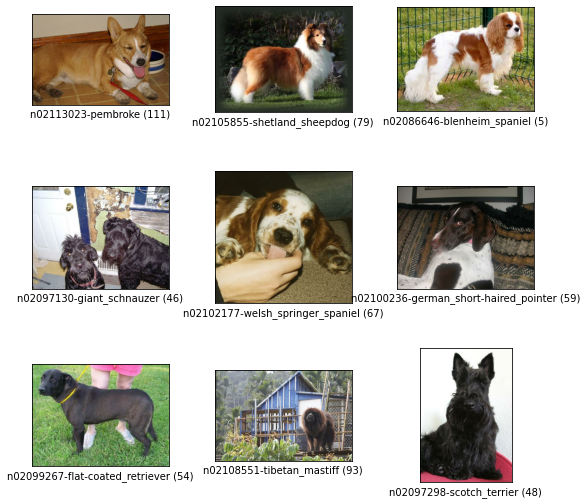

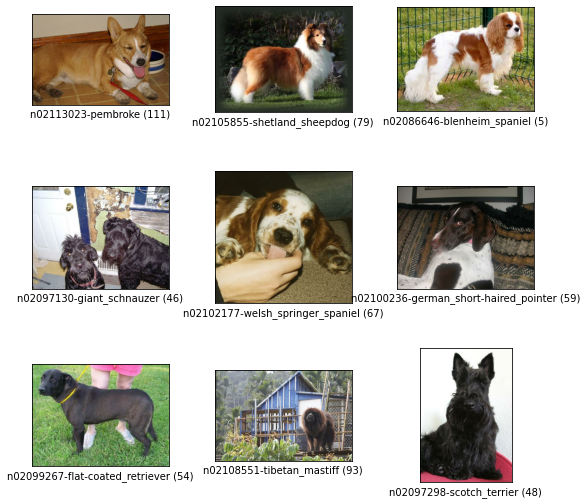

In [4]:
#다운로드 한 데이터 확인
tfds.show_examples(ds_train, ds_info)

### 1.2 Flip,brightness Augmentation

In [5]:
#이미지 변환 전처리 함수

def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    
    return tf.cast(image, tf.float32) / 255., label   #normalizing

In [6]:
#Argumentation 랜덤 적용 - flip,brightness
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    
    return image, label

In [7]:
#데이터 가공 함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  #기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       #augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

- Augmentation을 통해 원본 데이터셋에 다양한 형태의 가공한 형태의 새로운 데이터셋을 얻게 되는 모든 과정을 구현한 메인 함수임.
- 일반적인 전처리 과정인 normalize, resize, augmentation과 shuffle을 적용함.
- shuffle이나 augmentation은 테스트 데이터셋에는 적용하지 않아야 함.
- with_aug 매개변수를 통해 augmentation의 적용여부를 결정함.

In [8]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)

### 1.3 CutMix

In [9]:
num_classes = ds_info.features["label"].num_classes
num_classes

120

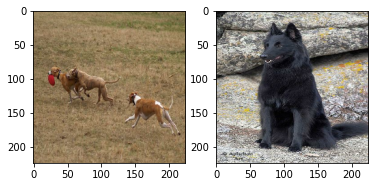

In [10]:
import matplotlib.pyplot as plt

#데이터셋에서 이미지 2개를 가져옴. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [11]:
#이미지a에 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수
def get_clip_box(image_a, image_b):
    
    #image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    #get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    #get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    #clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(98, shape=(), dtype=int32)
y :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(146, shape=(), dtype=int32)


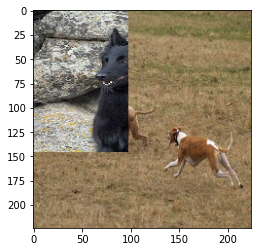

In [12]:
#이미지 a에서 바운딩 박스 바깥 영역, 이미지 b에서 바운딩 박스 안쪽 영역을 합치는 함수
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    
    #image_b의 왼쪽 바깥 영역
    middle_left = image_a[y_min:y_max, 0:x_min, :] 
    
    #image_b의 안쪽 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  
    
    #image_b의 오른쪽 바깥 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] 
    
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)

plt.imshow(mixed_img.numpy())
plt.show()

In [13]:
#섞인 이미지의 전체 이미지 대비 비율을 계산해서 두 가지 라벨의 비율로 더해주는 함수
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
        
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.71484375, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [14]:
#배치 단위의 cutmix() 함수
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    
    return mixed_imgs, mixed_labels

### 1.4 Mixup

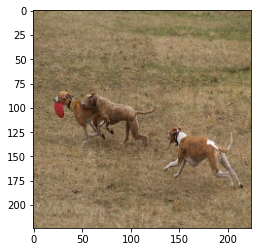

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.9011892  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.09881079 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

In [15]:
#mixup 함수
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
        
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label


mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)

plt.imshow(mixed_img.numpy())
plt.show()

print(mixed_label)

In [16]:
#배치단위의 mixup() 함수
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    
    return mixed_imgs, mixed_labels

### 1.5 데이터셋 만들기

In [17]:
def onehot(image, label) :
    label = tf.one_hot(label, num_classes)
    return image, label

In [18]:
#CutMix와 Mixup을 적용할 수 있도록 변경한 함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
        
    ds = ds.batch(batch_size)
    
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
        
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
        
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
        
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
        
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

In [19]:
#augmentation 적용 안한 데이터셋과 적용 한 데이터셋 생성

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)  #aug, cutmix, mixup 모두 안한 데이터셋
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)      #aug만 적용한 데이터셋
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)   #cutmix만 적용한 데이터셋
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)    #mixup만 적용한 데이터셋

ds_test = apply_normalize_on_dataset(ds_test, is_test = True)           #테스트 데이터셋

## 2. 모델 만들기
- 텐서플로우 케라스의 ResNet50 중 imagenet으로 훈련된 모델 사용

In [20]:
#aug, cutmix, mixup 모두 안한 데이터셋

#imagenet으로 훈련된 모델
resnet50_default = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,   #include_top은 마지막 fully connected layer를 포함할지 여부
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [21]:
#aug만 적용한 데이터셋

resnet50_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [22]:
#cutmix만 적용한 데이터셋

resnet50_cutmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [23]:
#mixup만 적용한 데이터셋

resnet50_mixup = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

## 3. 모델 훈련하기
- CutMix나 Mixup을 사용하기 위해서 categorical_crossentropy()를 사용해야 함.
-  cutmix(), mixup()을 구현하면서 label의 mix 때문에 더이상 label이 스칼라값을 가지지 못하고 One-Hot 벡터 형태로 변환되었기 때문.
- augmentation 효과 확인 위해서는 에폭 20은 수행해야 함.

In [24]:
#aug, cutmix, mixup 모두 안한 데이터셋

EPOCH = 20

resnet50_default.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)


history_resnet50_default = resnet50_default.fit(
    ds_train_no_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)


default_data = {'Default_accuracy' : history_resnet50_default.history['val_accuracy'],
                 'Default_loss' : history_resnet50_default.history['val_loss']
                }
default_df = pd.DataFrame(default_data)
default_df.to_csv(os.getenv('HOME') + '/aiffel/stanford_dogs/default_data.csv', index = 0)

Epoch 1/20
750/750 [==============================] - 347s 428ms/step - loss: 3.1667 - accuracy: 0.2807 - val_loss: 3.5685 - val_accuracy: 0.1840
Epoch 2/20
750/750 [==============================] - 321s 428ms/step - loss: 0.9400 - accuracy: 0.7364 - val_loss: 1.4488 - val_accuracy: 0.6052
Epoch 3/20
750/750 [==============================] - 322s 430ms/step - loss: 0.3470 - accuracy: 0.9142 - val_loss: 0.9585 - val_accuracy: 0.7169
Epoch 4/20
750/750 [==============================] - 321s 429ms/step - loss: 0.1199 - accuracy: 0.9793 - val_loss: 0.8924 - val_accuracy: 0.7414
Epoch 5/20
750/750 [==============================] - 322s 429ms/step - loss: 0.0346 - accuracy: 0.9984 - val_loss: 0.8970 - val_accuracy: 0.7485
Epoch 6/20
750/750 [==============================] - 321s 428ms/step - loss: 0.0176 - accuracy: 0.9995 - val_loss: 0.8989 - val_accuracy: 0.7493
Epoch 7/20
750/750 [==============================] - 321s 429ms/step - loss: 0.0110 - accuracy: 1.0000 - val_loss: 0.9181 -

In [25]:
#aug만 적용한 데이터셋

EPOCH = 20

resnet50_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = resnet50_aug.fit(
    ds_train_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

aug_data = {'Augmentation_accuracy' : history_resnet50_aug.history['val_accuracy'],
               'Augmentation_loss' : history_resnet50_aug.history['val_loss']
                }
aug_df = pd.DataFrame(aug_data)
aug_df.to_csv(os.getenv('HOME') + '/aiffel/stanford_dogs/aug_data.csv', index = 0)

Epoch 1/20
750/750 [==============================] - 328s 429ms/step - loss: 3.2814 - accuracy: 0.2642 - val_loss: 3.0130 - val_accuracy: 0.2727
Epoch 2/20
750/750 [==============================] - 322s 429ms/step - loss: 1.1069 - accuracy: 0.6876 - val_loss: 1.1693 - val_accuracy: 0.6508
Epoch 3/20
750/750 [==============================] - 322s 429ms/step - loss: 0.6061 - accuracy: 0.8311 - val_loss: 1.1127 - val_accuracy: 0.6788
Epoch 4/20
750/750 [==============================] - 322s 430ms/step - loss: 0.3161 - accuracy: 0.9198 - val_loss: 1.0308 - val_accuracy: 0.6993
Epoch 5/20
750/750 [==============================] - 322s 429ms/step - loss: 0.1815 - accuracy: 0.9593 - val_loss: 1.0484 - val_accuracy: 0.7046
Epoch 6/20
750/750 [==============================] - 321s 428ms/step - loss: 0.0926 - accuracy: 0.9855 - val_loss: 0.9403 - val_accuracy: 0.7352
Epoch 7/20
750/750 [==============================] - 322s 429ms/step - loss: 0.0559 - accuracy: 0.9935 - val_loss: 0.9413 -

In [26]:
#cutmix만 적용한 데이터셋

EPOCH = 20

resnet50_cutmix.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = resnet50_cutmix.fit(
    ds_train_cutmix,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

cutmix_data = {'CutMix_accuracy' : history_resnet50_cutmix.history['val_accuracy'],
                'CutMix_loss' : history_resnet50_cutmix.history['val_loss']
                }
cutmix_df = pd.DataFrame(cutmix_data)
cutmix_df.to_csv(os.getenv('HOME') + '/aiffel/stanford_dogs/cutmix_data.csv', index = 0)

Epoch 1/20
750/750 [==============================] - 330s 432ms/step - loss: 4.3572 - accuracy: 0.1127 - val_loss: 3.7172 - val_accuracy: 0.1634
Epoch 2/20
750/750 [==============================] - 324s 432ms/step - loss: 3.0683 - accuracy: 0.3959 - val_loss: 1.5012 - val_accuracy: 0.5910
Epoch 3/20
750/750 [==============================] - 324s 432ms/step - loss: 2.7038 - accuracy: 0.5086 - val_loss: 1.3932 - val_accuracy: 0.6115
Epoch 4/20
750/750 [==============================] - 324s 432ms/step - loss: 2.5182 - accuracy: 0.5724 - val_loss: 1.2683 - val_accuracy: 0.6480
Epoch 5/20
750/750 [==============================] - 324s 431ms/step - loss: 2.2994 - accuracy: 0.6424 - val_loss: 1.2114 - val_accuracy: 0.6637
Epoch 6/20
750/750 [==============================] - 324s 432ms/step - loss: 2.1699 - accuracy: 0.6815 - val_loss: 1.4439 - val_accuracy: 0.6074
Epoch 7/20
750/750 [==============================] - 323s 431ms/step - loss: 2.0652 - accuracy: 0.7085 - val_loss: 1.2516 -

In [27]:
#mixup만 적용한 데이터셋

EPOCH = 20

resnet50_mixup.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_mixup = resnet50_mixup.fit(
    ds_train_mixup,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

mixup_data = {'Mixup_accuracy' : history_resnet50_mixup.history['val_accuracy'],
                'Mixup_loss' : history_resnet50_mixup.history['val_loss']
                }
mixup_df = pd.DataFrame(mixup_data)
mixup_df.to_csv(os.getenv('HOME') + '/aiffel/stanford_dogs/mixup_data.csv', index = 0)

Epoch 1/20
750/750 [==============================] - 330s 432ms/step - loss: 4.2710 - accuracy: 0.1356 - val_loss: 4.7009 - val_accuracy: 0.0782
Epoch 2/20
750/750 [==============================] - 323s 431ms/step - loss: 2.9274 - accuracy: 0.4463 - val_loss: 1.6464 - val_accuracy: 0.5549
Epoch 3/20
750/750 [==============================] - 323s 431ms/step - loss: 2.6469 - accuracy: 0.5524 - val_loss: 1.4200 - val_accuracy: 0.6138
Epoch 4/20
750/750 [==============================] - 323s 431ms/step - loss: 2.4493 - accuracy: 0.6399 - val_loss: 1.2704 - val_accuracy: 0.6445
Epoch 5/20
750/750 [==============================] - 323s 431ms/step - loss: 2.3077 - accuracy: 0.6902 - val_loss: 1.1695 - val_accuracy: 0.6720
Epoch 6/20
750/750 [==============================] - 323s 431ms/step - loss: 2.2134 - accuracy: 0.7238 - val_loss: 1.2453 - val_accuracy: 0.6557
Epoch 7/20
750/750 [==============================] - 323s 430ms/step - loss: 2.0800 - accuracy: 0.7647 - val_loss: 1.2895 -

## 4. 훈련 과정 시각화하기

In [28]:
default_df = pd.read_csv(os.getenv('HOME') + '/aiffel/stanford_dogs/default_data.csv')
aug_df = pd.read_csv(os.getenv('HOME') + '/aiffel/stanford_dogs/aug_data.csv')
cutmix_df = pd.read_csv(os.getenv('HOME') + '/aiffel/stanford_dogs/cutmix_data.csv')
mixup_df = pd.read_csv(os.getenv('HOME') + '/aiffel/stanford_dogs/mixup_data.csv')

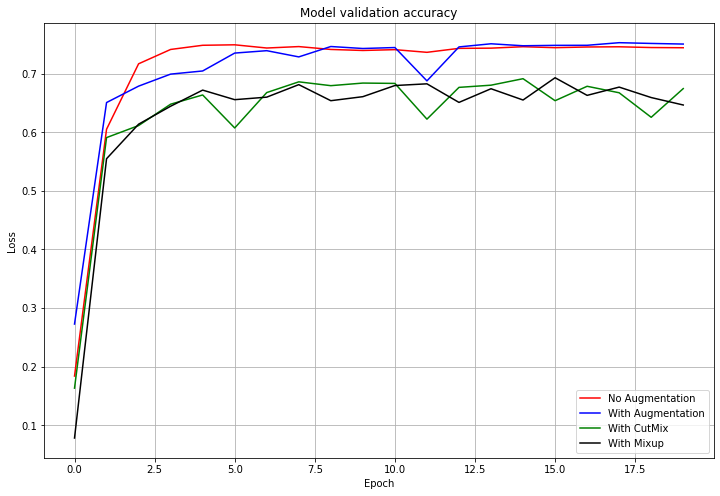

In [53]:
#accuracy 시각화
plt.figure(figsize=(12, 8))
plt.plot(default_df['Default_accuracy'], 'r')
plt.plot(aug_df['Augmentation_accuracy'], 'b')
plt.plot(cutmix_df['CutMix_accuracy'], 'g')
plt.plot(mixup_df['Mixup_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup'], loc='lower right')
plt.grid(True)
plt.show()

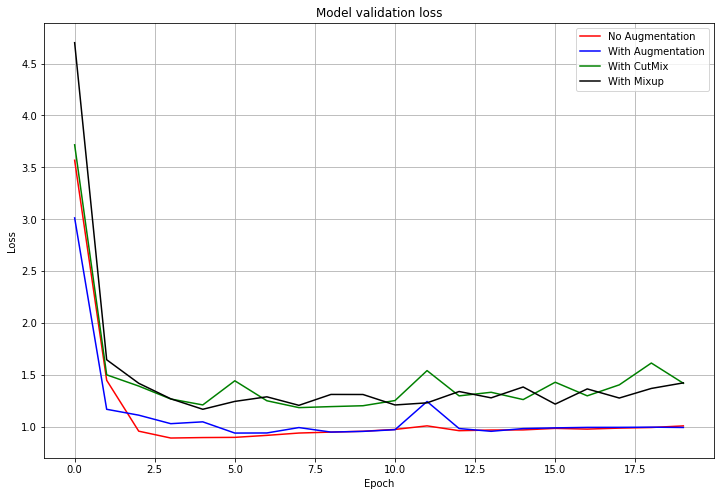

In [54]:
#loss 시각화
plt.figure(figsize=(12, 8))
plt.plot(default_df['Default_loss'], 'r')
plt.plot(aug_df['Augmentation_loss'], 'b')
plt.plot(cutmix_df['CutMix_loss'], 'g')
plt.plot(mixup_df['Mixup_loss'], 'k')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup'], loc='upper right')
plt.grid(True)
plt.show()

## 5. Augmentation에 의한 모델 성능 비교

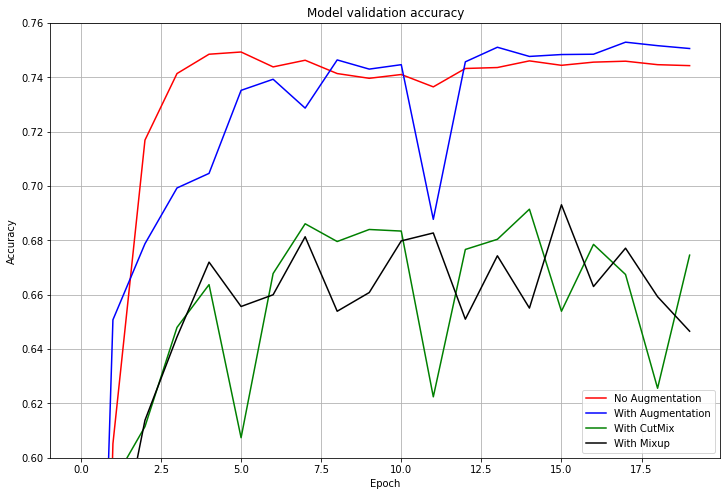

In [57]:
#accuracy 특정 범위 확대해서 시각화
plt.figure(figsize=(12, 8))
plt.plot(default_df['Default_accuracy'], 'r')
plt.plot(aug_df['Augmentation_accuracy'], 'b')
plt.plot(cutmix_df['CutMix_accuracy'], 'g')
plt.plot(mixup_df['Mixup_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup'], loc='lower right')
plt.grid(True)
plt.ylim(0.6, 0.76)  #출력하고자 하는 Accuracy 범위 지정
plt.show()

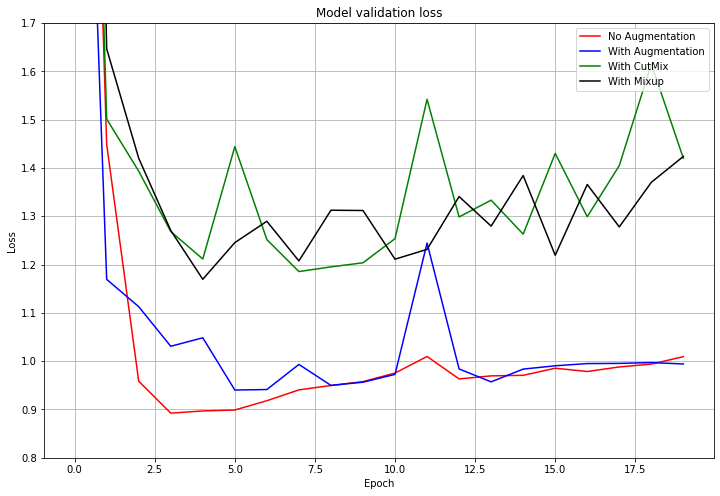

In [59]:
#loss 특정 범위 확대해서 시각화
plt.figure(figsize=(12, 8))
plt.plot(default_df['Default_loss'], 'r')
plt.plot(aug_df['Augmentation_loss'], 'b')
plt.plot(cutmix_df['CutMix_loss'], 'g')
plt.plot(mixup_df['Mixup_loss'], 'k')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup'], loc='upper right')
plt.grid(True)
plt.ylim(0.8, 1.7)  #출력하고자 하는 Accuracy 범위 지정
plt.show()

In [39]:
accuracy_data = {'No aug' : default_df['Default_accuracy'],
                'aug' : aug_df['Augmentation_accuracy'],
                'cutmix' : cutmix_df['CutMix_accuracy'],
                'mixup': mixup_df['Mixup_accuracy']}

accuracy_df = pd.DataFrame(accuracy_data)
accuracy_df.head()

,No aug,aug,cutmix,mixup
0,0.184002,0.272738,0.163363,0.078242
1,0.605177,0.650770,0.590952,0.554921
2,0.716884,0.678755,0.611474,0.613806
3,0.741371,0.699277,0.647971,0.644473
4,0.748484,0.704641,0.663713,0.671992


In [40]:
accuracy_df.describe()

,No aug,aug,cutmix,mixup
count,20.000000,20.000000,20.000000,20.000000
mean,0.707573,0.706372,0.632836,0.627857
std,0.127161,0.106144,0.114505,0.132714
min,0.184002,0.272738,0.163363,0.078242
25%,0.740672,0.703300,0.624796,0.649895
50%,0.743703,0.743820,0.667619,0.659632
75%,0.745657,0.748397,0.679775,0.675023
max,0.749300,0.752915,0.691465,0.693097


### 모델 성능 비교

#### 1. No Augmentation(default) vs With Augmentation(기본 Augmentation)   
- 정확도 값만 놓고 봤을 때는 미세한 차이로 기본 augmentation을 적용한 모델의 정확도가 augmentation을 하지 않은 모델 보다 조금 더 높다. 
- 위의 그래프 확대한 것을 보면 둘 다 초반에는 정확도가 거의 비슷했으나 augmentation을 적용한 모델이 좀 더 빠르게 성능이 좋아지고 있으며 Epoch 12부터는 augmentation을 적용한 모델의 성능이 더 좋아지는 것을 볼 수 있다.   

#### 2. 기본 Augmentation vs CutMix vs Mixup   
- 기본 augmentation을 적용한 모델의 성능이 가장 좋았다. 
- 랜덤으로 augmentation을 적용도 해 봤으나 결론적으로 심화 기법인 cutmix와 mixup보다 기본 augmentation의 성능이 좀 더 좋았다. 

#### 3. 태스크에 최적인 Augmentation 기법   
- 위의 결과를 종합하면 해당 데이터에 최적인 augmentation 기법은 기본 augmentation으로 적용한 Flip과 brightness라고 판단할 수 있다.

---

## - 프로젝트 정리

#### 1. 프로젝트 진행 
- 모델 학습 시간이 꽤 오래(약 7시간) 걸리기도 했으며 학습 중간에 또 컨테이너 연결이 끊기면서 학습이 원활하게 이루어지지 않아 다양한 시도를 해 보지 못한 것이 아쉬웠다.
- 다시 학습을 진행하면서 컨테이너 연결이 또 끊어지는 것을 우려해 history를 전부 dataframe으로 저장을 했고 덕분에 시각화와 결과 비교를 비교적 편하게 할 수 있었다.   


#### 2. 성능 개선
- augmentation을 적용하지 않은 것 보다 적용한 모델이 성능이 조금 더 좋은 것을 보아 augmentation 기법이 성능을 높이는데 기여하는 것이 사실이라는 것을 알 수 있었다.
- 하지만 큰 차이가 나지 않으며 심화 기법인 cutmix, mixup의 성능은 좋지 않은 것으로 보아 데이터셋에 문제가 있다고 판단했다.
- 보통 모델의 성능을 높이기 위해 augmentation을 적용할 땐 기존 데이터셋에 augmentation을 적용한 데이터셋을 추가로 더해주는데, 해당 프로젝트에서는 기존 데이터셋에 추가하는 것이 아니라 augmnetation을 적용한 데이터셋으로만 모델 학습을 진행했기 때문에 제대로 된 성능 개선이 이루어지지 않았다고 생각한다.
- 또 바운딩 박스를 랜덤으로 뽑아 두 이미지를 합성한 cutmix는 랜덤하게 바운딩 박스를 뽑으면서 개와 무관한 부분이 합성되기도 하여 모델의 성능을 저하시켰을 것이라 생각한다.